# Model training for NFL play prediction

---
 
In this notebook, we train multiple regression and ANN models to predict the yards gained per football play. As a basis we use the preselected data created by the `preprocessing.py``.

### Inline preprocessing steps:

---

As we use 5-fold cross-validation to protect the model against overfitting, we need a dynamic preprocessing appraoch. Therefore a pipeline provided by the `preprocessing.py`` will be used to process the training data of each fold. Further we use a nested cross validation to ensure the quality of our model using selected hyperparameters.


### Contributors

All contributors are only assigned to their primary task, the teams still interchanged know-how and worked on one anothers approaches.

---

##### Preprocessing Team

- Tim Oliver Krause (1689074)
- Jan Thilo Viktorin (1684159)
- Joël Pflomm (1634591)

##### Model Team

- Franziska Köllschen (1981780)
- Steffen Hüls (1979863)
- Matthias Biermanns (1980701)

## Coding

### Coding Foundations

In [38]:
# basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.base import TransformerMixin, BaseEstimator
import preprocessing

# import for data visualization
import matplotlib.pyplot as plt

# imports for regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb

In [39]:
# static variables
FILE_LIST = [f'./Data/play_by_play_{year}.csv' for year in range(1999, 2001)]
PREPROCESSOR = preprocessing.NFLPreprocessing(FILE_LIST)
TARGET_NAME = 'yards_gained'
RANDOM_STATE = 42
LABEL_PASS = 'Pass'
LABEL_RUN = 'Run'

2023-12-02 17:16:13.307 | INFO     | preprocessing:__init__:58 - --- Executing Preprocessing Steps ---
2023-12-02 17:16:13.310 | INFO     | preprocessing:make_combined_df:152 - Loading csv files
/Users/I538844/Library/CloudStorage/OneDrive-SAPSE/Master/1. Semester/Data Mining/Projekt/NFL_play_prediction/preprocessing.py:157: DtypeWarning: Columns (36,37,179,180,189,190,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
/Users/I538844/Library/CloudStorage/OneDrive-SAPSE/Master/1. Semester/Data Mining/Projekt/NFL_play_prediction/preprocessing.py:157: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
2023-12-02 17:16:15.357 | INFO     | pr

##### General functions

In [40]:
def split_feature_target(df, data_fraction=1):
    # set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
    df_sampled = df.sample(frac=data_fraction, random_state=RANDOM_STATE)

    # Reset the index if needed
    df_sampled = df_sampled.reset_index(drop=True)

    features = df_sampled.drop(TARGET_NAME, axis=1)
    target = df_sampled[TARGET_NAME]

    return features, target

def visualize_predicts(y_test, predictions, label):
    # Visualize predictions for passes
    plt.scatter(y_test, predictions)
    plt.title(label + ' Model: True vs Predicted Yards')
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

def plot_decision_tree(tree, label):
    # Plot the decision tree for runs
    plt.figure(figsize=(15, 10))
    plot_tree(tree, filled=True, feature_names=PREPROCESSOR.get_prepro_feature_names_from_pipeline())
    plt.title('Decision Tree for ' + label + ' Model')
    plt.show()

def visualize_train_val_loss(training_losses, validation_losses, label):
    # Plot the training and validation loss
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss - ' + label)
    plt.legend()
    plt.show()

def plot_feature_importances(pipeline, show_top_n=10):
    # Get feature importances
    feature_importances = pipeline.named_steps['regressor'].feature_importances_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'][:show_top_n], feature_importance_df['Importance'][:show_top_n])
    plt.xlabel('Importance')
    plt.title('Top {} Feature Importances'.format(show_top_n))
    plt.show()

def plot_coef(pipeline):
    coefs = pipeline.named_steps['regressor'].coef_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    coef = pd.DataFrame(coefs, columns=["Coefficients"], index=columns)
    coef.plot(kind="barh", figsize=(9, 7))
    plt.figure(figsize=(10, 6))
    plt.title("Ridge model")
    plt.axvline(x=0, color=".5")
    plt.subplots_adjust(left=0.3)

##### Functions for cross validation

In [41]:
def test_model(pipeline, x_train, y_train, x_test, y_test):
    pipeline.fit(x_train, y_train)

    # Make predictions on the test set
    predictions = pipeline.predict(x_test)

    # Evaluate the models
    pass_mse = mean_squared_error(y_test, predictions)
    pass_rmse = mean_squared_error(y_test, predictions, squared = False)
    pass_msa = mean_absolute_error(y_test, predictions)

    print(f"Mean Squared Error: {pass_mse}")
    print(f"Mean Absolute Error: {pass_msa}")
    print(f"Root Mean Squared Error: {pass_rmse}")
    return predictions

def test_model_k_fold(df, pipeline, data_fraction, k_folds=5):
    features, target = split_feature_target(df, data_fraction)
    
    cv_results = cross_val_predict(pipeline, features, target, cv=k_folds)
    #print(f"Run Model Cross-Validation Mean Squared Error: {np.mean(cv_results)}")
    #print(f"Run Model Cross-Validation Max Squared Error: {np.max(cv_results)}")
    return cv_results

def estimate_hyperparams(features, target, pipeline, scoring, k_folds=5, parameters={}):
    # create the grid search instance
    grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=scoring, cv=k_folds, return_train_score=False)

    # run the grid search
    grid_search_estimator.fit(features, target)

    return grid_search_estimator

##### MLP Regressor Class - with history

In [42]:
class MLPWithHistory(BaseEstimator, TransformerMixin):
    def __init__(self, mlp_params=None):
        self.mlp_params = mlp_params
        self.training_losses = []
        self.validation_losses = []
        self.mlp_regressor = MLPRegressor(**(self.mlp_params or {}))

    def fit(self, X, y):
        X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        for epoch in range(self.mlp_regressor.max_iter):
            self.mlp_regressor.partial_fit(X, y)

            # Calculate training loss
            y_train_pred = self.mlp_regressor.predict(X)
            training_loss = mean_squared_error(y, y_train_pred)
            self.training_losses.append(training_loss)

            # Calculate validation loss
            y_val_pred = self.mlp_regressor.predict(X_val)
            validation_loss = mean_squared_error(y_val, y_val_pred)
            self.validation_losses.append(validation_loss)

        return self

    def transform(self, X):
        return X

    def predict(self, X):
        return self.mlp_regressor.predict(X)

    def get_params(self, deep=True):
        return {"mlp_params": self.mlp_params}

    def set_params(self, **params):
        self.mlp_params = params["mlp_params"]
        self.mlp_regressor.set_params(**self.mlp_params)
        return self
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

##### Train and Test Data

In [43]:
run_df = PREPROCESSOR.run_df
pass_df = PREPROCESSOR.pass_df

run_features, run_target = split_feature_target(run_df, 0.2)
pass_features, pass_target = split_feature_target(pass_df, 0.2)

run_X_train, run_X_test, run_y_train, run_y_test = train_test_split(run_features, run_target)
pass_X_train, pass_X_test, pass_y_train, pass_y_test = train_test_split(pass_features, pass_target)

print(run_features.shape)
print(pass_features.shape)

run_features

(5463, 24)
(6461, 24)


,season_type,posteam_type,yardline_100,half_seconds_remaining,down,goal_to_go,ydstogo,ydsnet,shotgun,no_huddle,...,td_prob,first_down_rush,first_down_pass,season,drive_play_count,drive_start_yard_line,spread_line,total_line,div_game,roof
0,REG,home,78.0,733.0,1.0,0.0,10,9,0,0,...,0.283411,0.0,0.0,1999,4,22,7.0,37.0,1,outdoors
1,REG,home,35.0,69.0,1.0,0.0,10,36,0,0,...,0.237635,0.0,0.0,2000,5,26,6.5,38.0,0,dome
2,REG,away,85.0,603.0,1.0,0.0,10,24,0,0,...,0.222641,0.0,0.0,2000,7,15,-8.0,36.5,1,outdoors
3,REG,away,53.0,696.0,1.0,0.0,10,19,0,0,...,0.368306,0.0,0.0,2000,4,37,-9.5,42.5,1,outdoors
4,POST,away,80.0,1090.0,1.0,0.0,10,2,0,0,...,0.324459,0.0,0.0,1999,3,20,-7.0,46.5,0,dome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,REG,home,45.0,259.0,1.0,0.0,20,29,0,0,...,0.302504,0.0,0.0,2000,10,42,7.0,36.5,1,outdoors
5459,REG,away,48.0,196.0,1.0,0.0,10,17,0,0,...,0.270335,0.0,0.0,1999,4,39,3.0,40.5,0,outdoors
5460,REG,home,39.0,1437.0,2.0,0.0,8,-2,0,0,...,0.414202,0.0,0.0,1999,3,41,1.0,38.5,1,outdoors
5461,REG,away,80.0,243.0,3.0,0.0,10,1,0,0,...,0.132692,0.0,0.0,2000,5,9,-4.5,38.5,0,outdoors


### Linear Regression

Mean Squared Error: 28.604005915365615
Mean Absolute Error: 3.6462803963072794
Root Mean Squared Error: 5.348271301585739
Mean Squared Error: 102.36622900696885
Mean Absolute Error: 7.096901370140439
Root Mean Squared Error: 10.117619730300643


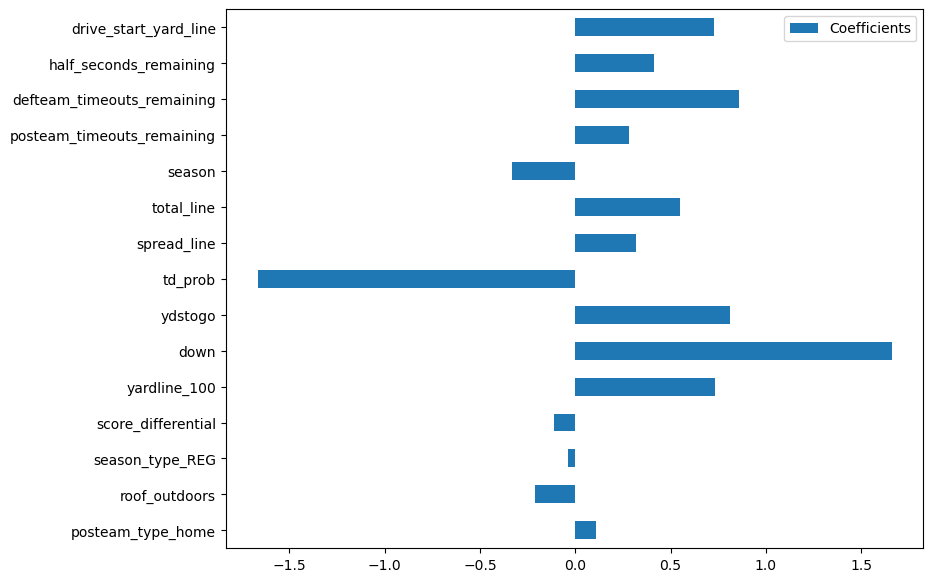

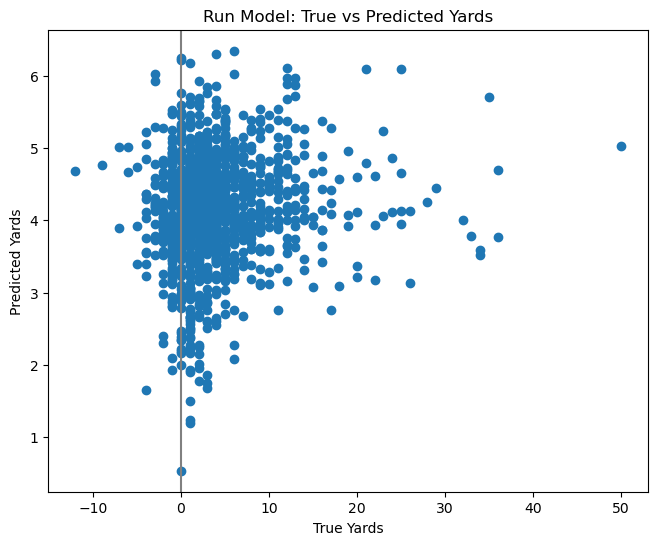

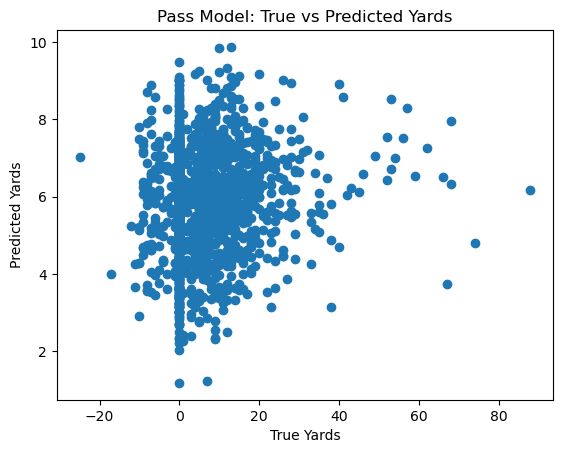

In [44]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.0,
        'loose_factor_iqr': 2.0,
        'strict_columns': ['yardline_100', 'ydstogo'],
        'omit_columns': []
    }
}

pass_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }
}

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model(pipeline, run_X_train, run_y_train, run_X_test, run_y_test)

plot_coef(pipeline)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model(pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [45]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_cv_scores = cross_val_score(pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")


Run Model Cross-Validation Mean Squared Error: 34.41139516177502


In [46]:
# hyperparameter tuning for linear regression

# could be more over engineered with automatic dict creation if necessary
run_params = {
    'outlier_remover__kw_args': [
        {
            'strict_factor_iqr': 1.0,
            'loose_factor_iqr': 2.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        }, {
            'strict_factor_iqr': 1.5,
            'loose_factor_iqr': 3.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        },
    ]
}

pass_params = {
    'outlier_remover__kw_args': [{
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }]
}

pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_grid_search = estimate_hyperparams(run_features, run_target, pipeline, scoring='neg_mean_squared_error', parameters=run_params)
pass_grid_search = estimate_hyperparams(pass_features, pass_target, pipeline, scoring='neg_mean_squared_error', parameters=pass_params)

display(run_grid_search.best_params_)
display(pd.DataFrame(run_grid_search.cv_results_))
display(pass_grid_search.best_params_)
display(pd.DataFrame(pass_grid_search.cv_results_))

{'outlier_remover__kw_args': {'strict_factor_iqr': 1.5,
  'loose_factor_iqr': 3.0,
  'strict_columns': ['yardline_100', 'ydstogo'],
  'omit_columns': []}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013310,0.001836,0.002860,0.000568,"{'strict_factor_iqr': 1.0, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-34.381171,-38.247318,-33.858597,-30.135243,-36.459185,-34.616303,2.730926,2
1,0.012316,0.001643,0.006402,0.007946,"{'strict_factor_iqr': 1.5, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-34.513001,-38.127382,-33.407169,-30.011843,-36.156667,-34.443212,2.728528,1


{'outlier_remover__kw_args': {'strict_factor_iqr': 1.5,
  'loose_factor_iqr': 3.0,
  'strict_columns': ['ydstogo'],
  'omit_columns': []}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012526,0.001325,0.002528,0.000573,"{'strict_factor_iqr': 1.5, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-85.972068,-102.576482,-113.355089,-101.118622,-103.802778,-101.365008,8.811081,1


Mean Squared Error: 28.550258921669307
Mean Absolute Error: 3.606152912279541
Root Mean Squared Error: 5.343244231894075
Mean Squared Error: 102.36622900696885
Mean Absolute Error: 7.096901370140439
Root Mean Squared Error: 10.117619730300643


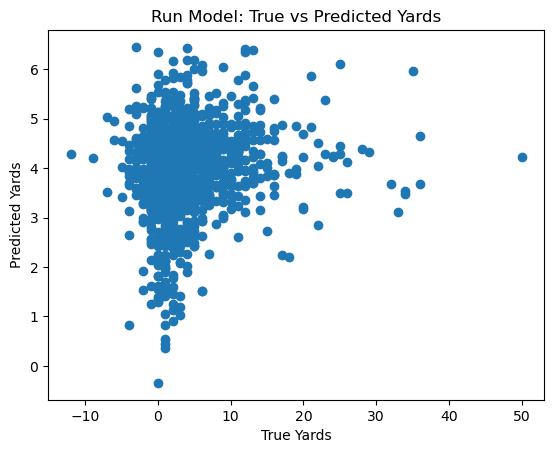

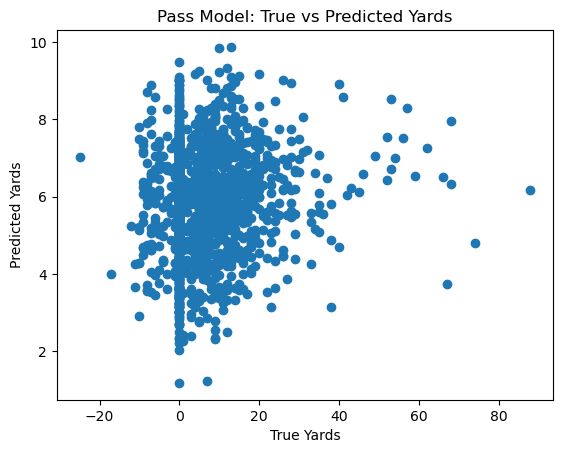

In [47]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_predictions = test_model(pipeline, run_X_train, run_y_train, run_X_test, run_y_test)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_predictions = test_model(pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

### Polynomial Regression

Mean Squared Error: 29.927770738035598
Mean Absolute Error: 3.717323693227279
Root Mean Squared Error: 5.470628002161689
Mean Squared Error: 107.02976380495883
Mean Absolute Error: 7.257002781523337
Root Mean Squared Error: 10.345519020569187


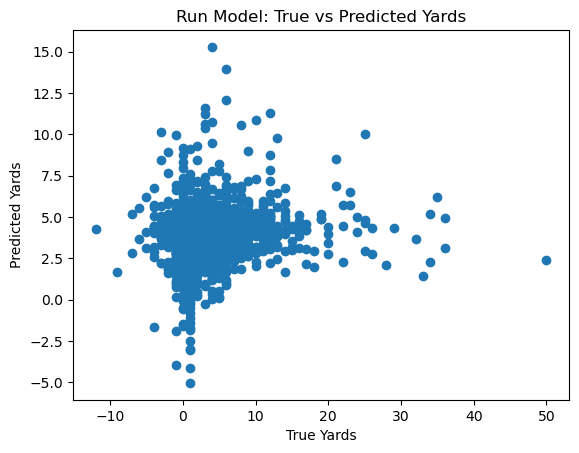

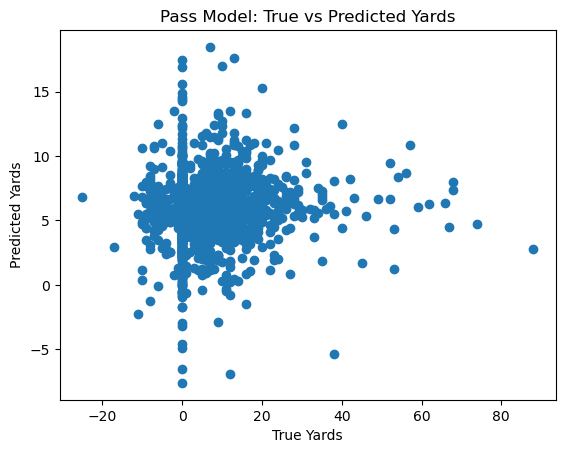

In [48]:
# basic model

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [49]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(), LinearRegression()))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(), LinearRegression()))

parameters = {
    'regressor__polynomialfeatures__degree': [2, 3]
}

run_grid_search = estimate_hyperparams(run_features, run_target, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_grid_search = estimate_hyperparams(pass_features, pass_target, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_grid_search.best_params_)
display(pass_grid_search.best_params_)

{'regressor__polynomialfeatures__degree': 3}

{'regressor__polynomialfeatures__degree': 3}

In [50]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(), LinearRegression()))

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

pipeline = pipeline.set_params(**run_params)
run_cv_scores = cross_val_score(pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")

pipeline = pipeline.set_params(**pass_params)
pass_cv_scores = cross_val_score(pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 588.0865673453688
Pass Model Cross-Validation Mean Squared Error: 1363.474448749543


### KNN

Mean Squared Error: 38.355620627948596
Mean Absolute Error: 4.28696925329429
Root Mean Squared Error: 6.193191473541618
Mean Squared Error: 138.68110561056108
Mean Absolute Error: 8.283003300330032
Root Mean Squared Error: 11.776294222316334


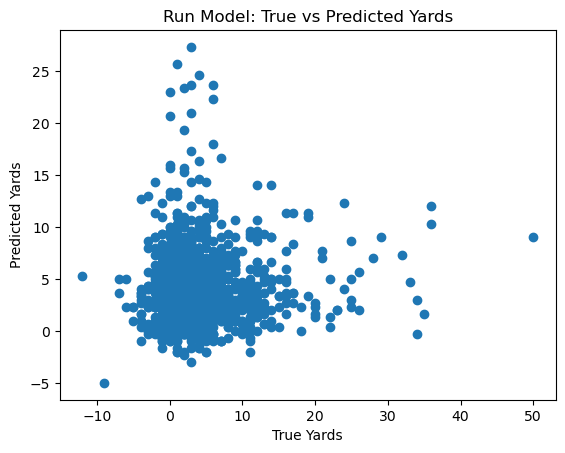

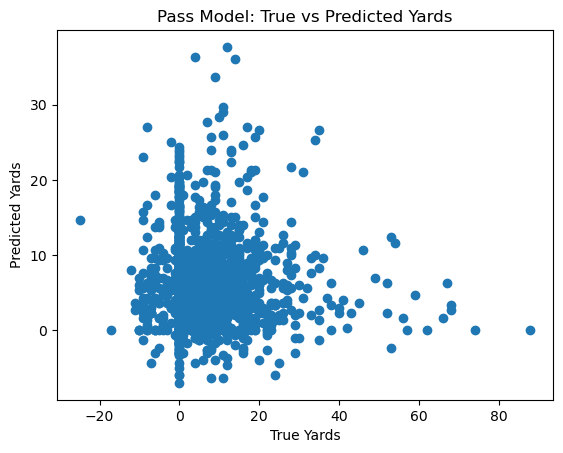

In [51]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [52]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.1)
pass_features, pass_target = split_feature_target(pass_df, 0.1)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

parameters = {
    'regressor__n_neighbors': range(1, 10)
}

run_grid_search = estimate_hyperparams(run_features, run_target, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_grid_search = estimate_hyperparams(pass_features, pass_target, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_grid_search.best_params_)
display(pass_grid_search.best_params_)

{'regressor__n_neighbors': 9}

{'regressor__n_neighbors': 9}

In [53]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

pipeline = pipeline.set_params(**run_params)
run_cv_scores = cross_val_score(run_pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")

pipeline = pipeline.set_params(**pass_params)
pass_cv_scores = cross_val_score(pass_pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 43.329655169650536
Pass Model Cross-Validation Mean Squared Error: 117.97932168864581


### Random Forest

Mean Squared Error: 28.63788248132623
Mean Absolute Error: 3.6313324273877168
Root Mean Squared Error: 5.351437421976102


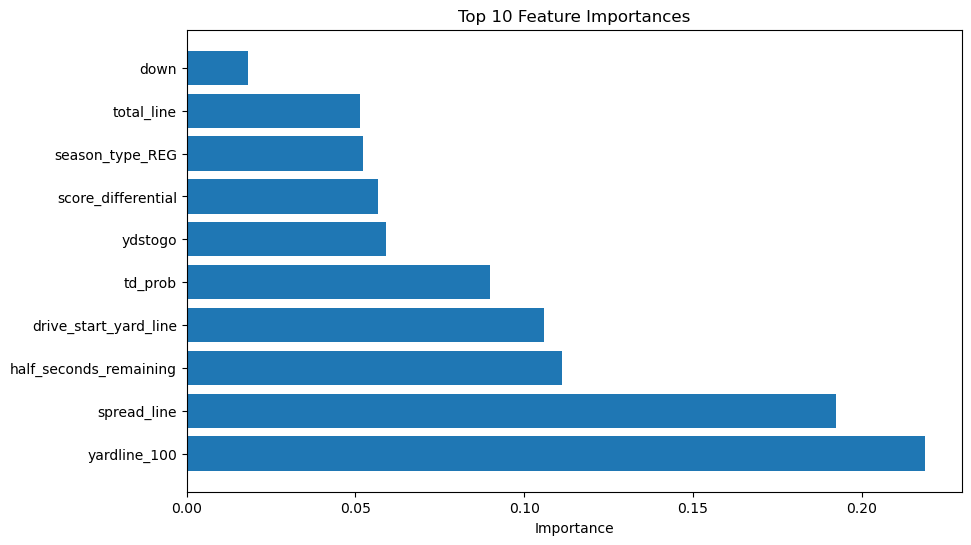

Mean Squared Error: 101.96573924258216
Mean Absolute Error: 7.08611156458011
Root Mean Squared Error: 10.09780863566854


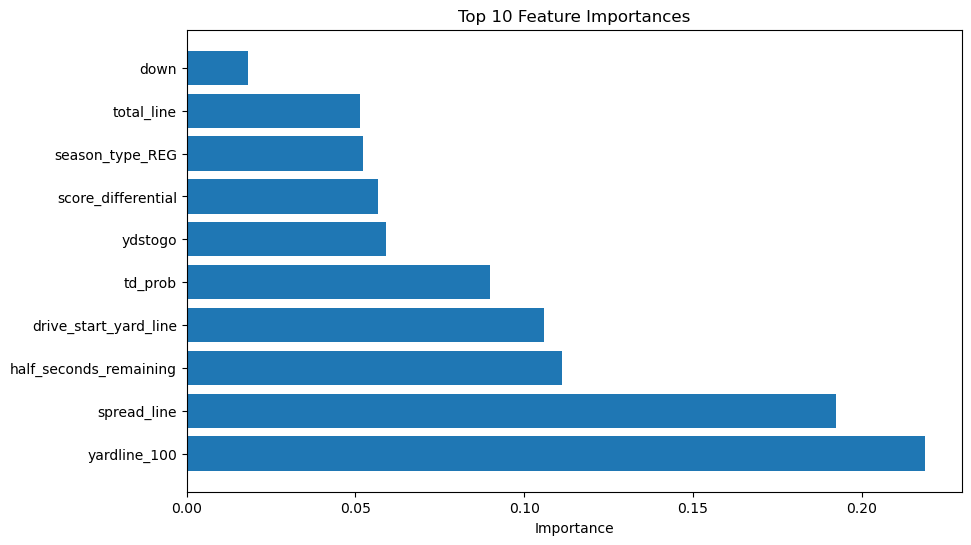

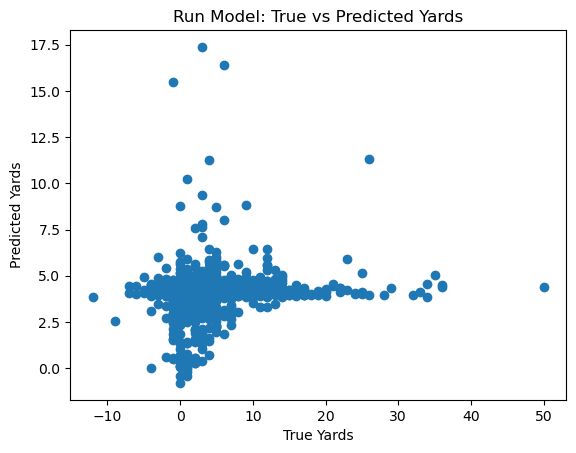

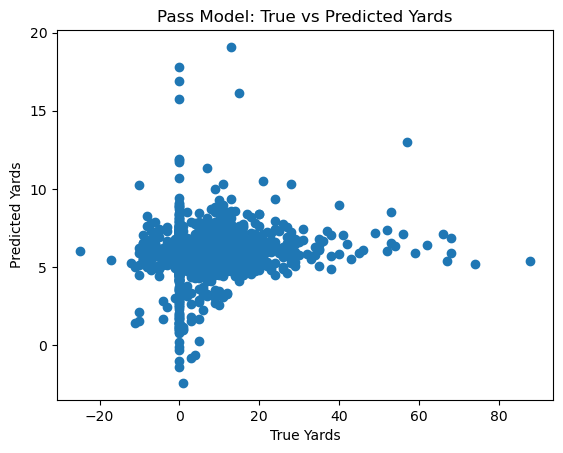

In [54]:
# Basic model

# make pipelines
from sklearn.pipeline import Pipeline

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
plot_feature_importances(run_pipeline)

pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)
plot_feature_importances(run_pipeline)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [55]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

parameters = {
    'regressor__max_depth': range(4, 7),
    'regressor__n_estimators': [20, 50, 100]
}

run_grid_search = estimate_hyperparams(run_features, run_target, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_grid_search = estimate_hyperparams(pass_features, pass_target, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_grid_search.best_params_)
display(pass_grid_search.best_params_)

{'regressor__max_depth': 4, 'regressor__n_estimators': 20}

{'regressor__max_depth': 4, 'regressor__n_estimators': 100}

In [56]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

pipeline = pipeline.set_params(**run_params)
run_cv_scores = cross_val_score(pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")
pipeline = pipeline.set_params(**pass_params)
pass_cv_scores = cross_val_score(pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 36.72402816597404
Pass Model Cross-Validation Mean Squared Error: 97.76453896460143


Mean Squared Error: 32.506935871156664
Mean Absolute Error: 3.925534407027819
Root Mean Squared Error: 5.701485409185633
Mean Squared Error: 107.4438306930693
Mean Absolute Error: 7.381175742574257
Root Mean Squared Error: 10.365511598231382


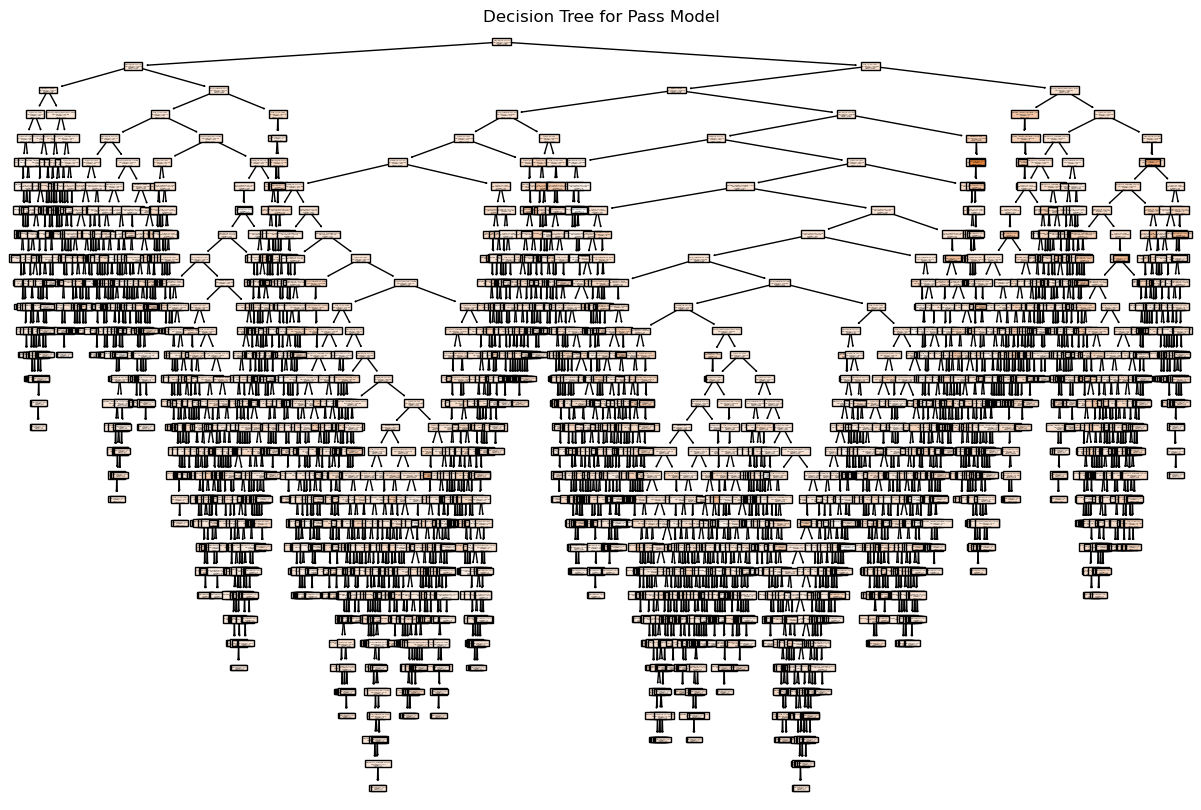

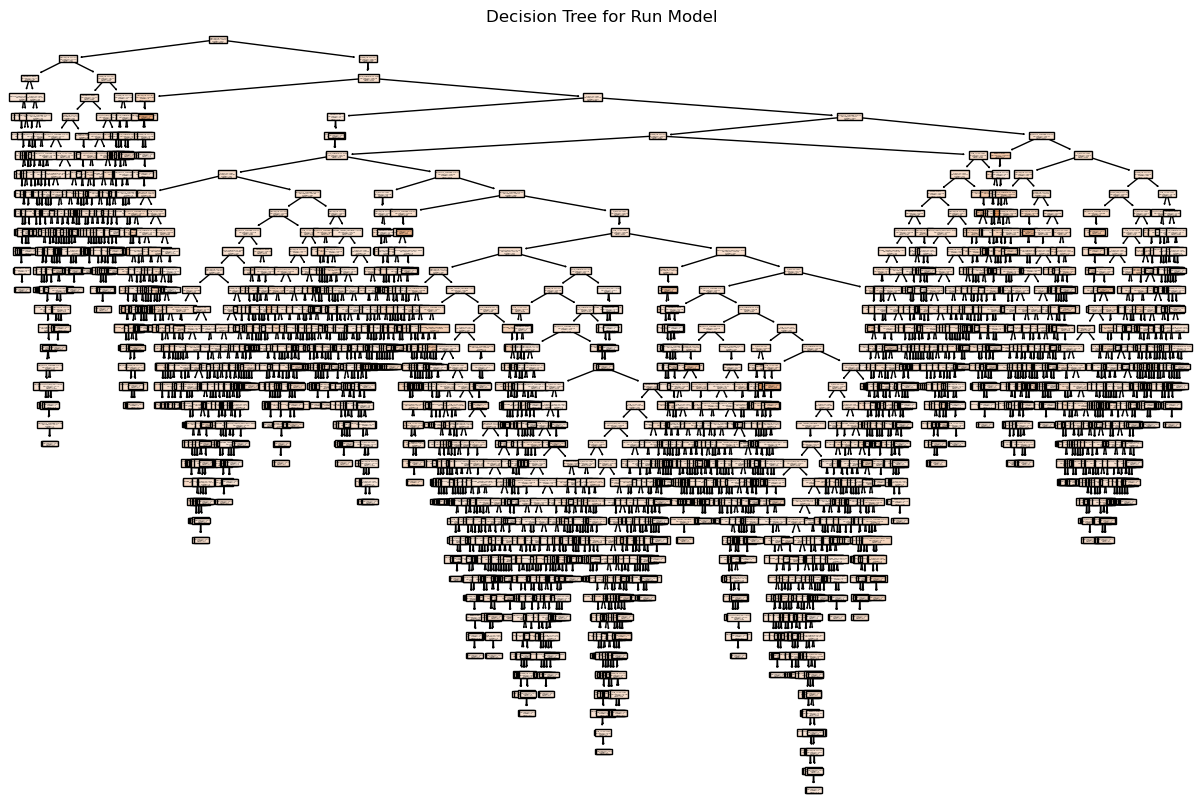

In [57]:
# visualize decision tree
# test model
test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# Access a specific tree from the forest (e.g., the first tree)
tree_to_plot_pass = 0
tree_to_plot_run = 0

pass_rf_regressor = pass_pipeline.named_steps['regressor']
run_rf_regressor = run_pipeline.named_steps['regressor']

# Access the decision tree from the Random Forest
individual_tree_pass = pass_rf_regressor.estimators_[tree_to_plot_pass]
individual_tree_run = run_rf_regressor.estimators_[tree_to_plot_run]

# Plot the decision tree for passes
plot_decision_tree(individual_tree_pass, LABEL_PASS)

# Plot the decision tree for runs
plot_decision_tree(individual_tree_run, LABEL_RUN)

### XGBoost

Mean Squared Error: 36.30361636572627
Mean Absolute Error: 4.098699023421461
Root Mean Squared Error: 6.0252482410043715
Mean Squared Error: 116.7736666884051
Mean Absolute Error: 7.7020801164009285
Root Mean Squared Error: 10.806186500722866


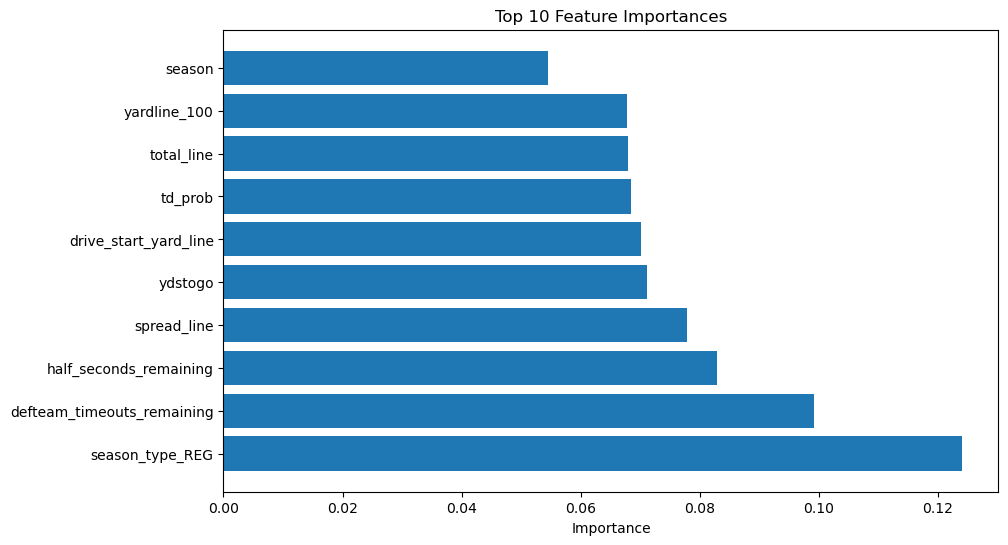

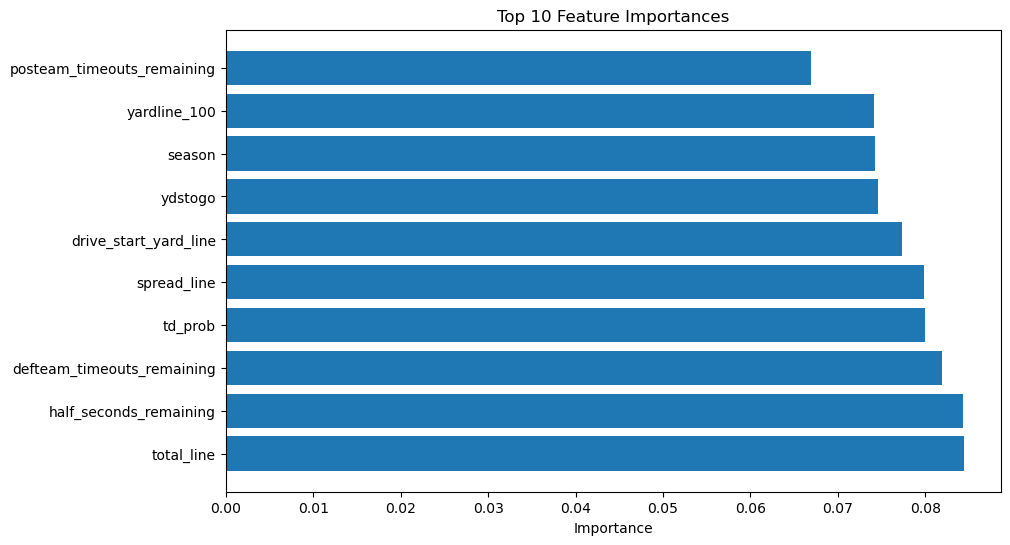

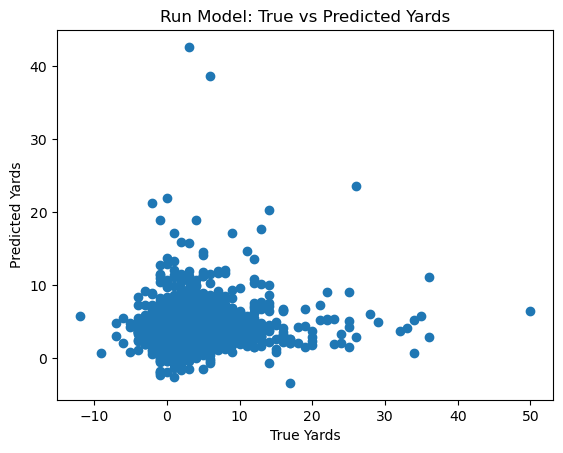

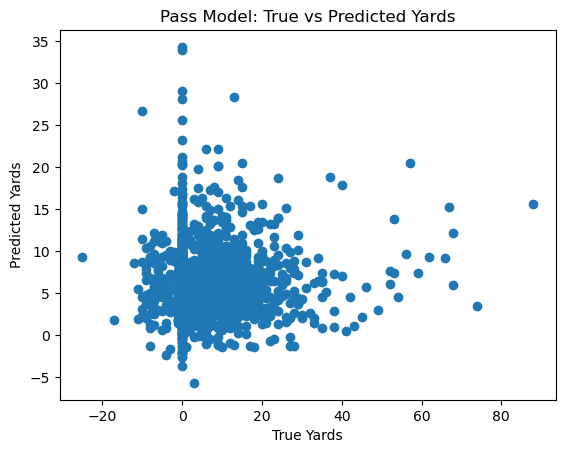

In [58]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.022,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
                           )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.015,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
        )
)

# test model and save predictions
run_predictions = test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
pass_predictions = test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

plot_feature_importances(run_pipeline)
plot_feature_importances(pass_pipeline)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

In [60]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.05)
pass_features, pass_target = split_feature_target(pass_df, 0.05)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

parameters = {
    "regressor__max_depth":    [8, 10],
    "regressor__n_estimators": [1000, 1100],
    "regressor__learning_rate": [0.022, 0.015]
}

run_grid_search = estimate_hyperparams(run_features, run_target, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_grid_search = estimate_hyperparams(pass_features, pass_target, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_grid_search.best_params_)
display(pass_grid_search.best_params_)

{'regressor__learning_rate': 0.015,
 'regressor__max_depth': 8,
 'regressor__n_estimators': 1000}

{'regressor__learning_rate': 0.015,
 'regressor__max_depth': 8,
 'regressor__n_estimators': 1000}

### Artificial Neuronal Network

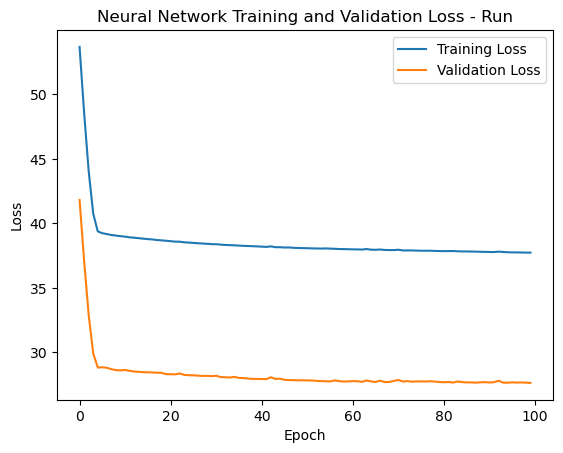

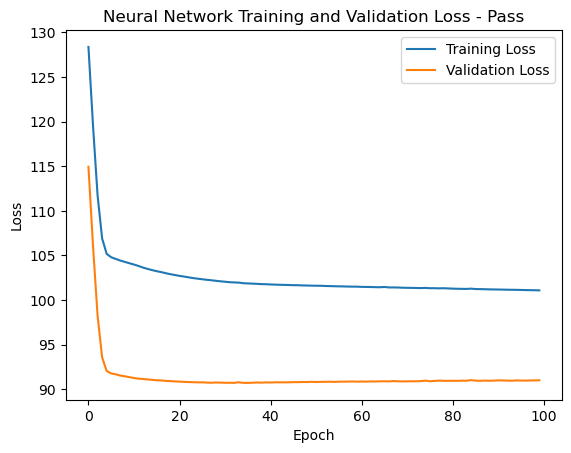

Mean Squared Error (MSE) for run plays: 28.29415026597009
Mean Squared Error (MSE) for pass plays: 102.55459994195733


In [61]:
# Basic model

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)

# Fit the pipelines
run_pipeline.fit(run_X_train, run_y_train)
pass_pipeline.fit(pass_X_train, pass_y_train)

run_mlp = run_pipeline.named_steps['regressor']
pass_mlp = pass_pipeline.named_steps['regressor']

# Plot the training and validation loss
visualize_train_val_loss(run_mlp.training_losses, run_mlp.validation_losses, LABEL_RUN)
visualize_train_val_loss(pass_mlp.training_losses, pass_mlp.validation_losses, LABEL_PASS)

# Evaluate the neural network for run plays
y_run_pred = run_pipeline.predict(run_X_test)
mse_run = mean_squared_error(run_y_test, y_run_pred)
print(f"Mean Squared Error (MSE) for run plays: {mse_run}")

# Evaluate the neural network for pass plays
y_pass_pred = pass_pipeline.predict(pass_X_test)
mse_pass = mean_squared_error(pass_y_test, y_pass_pred)
print(f"Mean Squared Error (MSE) for pass plays: {mse_pass}")


In [62]:
# estimating hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

parameters = {
    'regressor__mlp_params': [
        {'hidden_layer_sizes': (10,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (10, 5), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (20, 10), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    ]
}

run_estimator = estimate_hyperparams(run_features, run_target, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)
pass_estimator = estimate_hyperparams(pass_features, pass_target, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters)

display(run_estimator.best_params_)
display(pd.DataFrame(run_estimator.cv_results_))
display(pass_estimator.best_params_)
display(pd.DataFrame(pass_estimator.cv_results_))

{'regressor__mlp_params': {'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__mlp_params,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.037263,0.003557,0.002507,0.000827,"{'hidden_layer_sizes': (10,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-8.512037,-4.011738,-6.762378,-6.428718,1.852326,4
1,0.041123,0.000919,0.004606,0.003424,"{'hidden_layer_sizes': (50,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-7.369485,-4.021009,-6.817722,-6.069405,1.465846,1
2,0.038432,0.000812,0.001967,0.000048,"{'hidden_layer_sizes': (10, 5), 'activation': ...",{'regressor__mlp_params': {'hidden_layer_sizes...,-7.645197,-4.007134,-6.911966,-6.188099,1.570958,3
3,0.040340,0.000310,0.002171,0.000357,"{'hidden_layer_sizes': (20, 10), 'activation':...",{'regressor__mlp_params': {'hidden_layer_sizes...,-7.524865,-4.064296,-6.821196,-6.136786,1.493363,2


{'regressor__mlp_params': {'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__mlp_params,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035536,0.000561,0.001930,0.000056,"{'hidden_layer_sizes': (10,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-11.193167,-9.046908,-11.056828,-10.432301,0.981201,3
1,0.043743,0.001278,0.007279,0.006848,"{'hidden_layer_sizes': (50,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-10.882956,-8.573660,-10.584919,-10.013845,1.025608,1
2,0.041221,0.001437,0.002144,0.000149,"{'hidden_layer_sizes': (10, 5), 'activation': ...",{'regressor__mlp_params': {'hidden_layer_sizes...,-11.836364,-9.029542,-11.808808,-10.891571,1.316702,4
3,0.052454,0.011008,0.002751,0.000815,"{'hidden_layer_sizes': (20, 10), 'activation':...",{'regressor__mlp_params': {'hidden_layer_sizes...,-11.009045,-8.545701,-11.516198,-10.356981,1.297396,2
